## Page layout block ordering algorithm

In [88]:
import shapely
import networkx
import intervaltree

DEFAULT_SHRINK_RATIO = 1 / 7
DEFAULT_MAX_SHRINK_PX = 32
CLASSES_SEGMENTATION = [ 
    {
        "label": "background",
        "id": 0,
        "color": [0, 0, 0],
    },
    {
        "label": "text",
        "id": 1,
        "color": [67, 57, 129],
    },
    {
        "label": "mixed",
        "id": 2,
        "color": [255, 72, 48],
    },
    {
        "label": "graphics",
        "id": 3,
        "color": [170, 214, 82],
    }
]

def get_iu(amin, amax, bmin, bmax):
    intersection = min(amax, bmax) - max(amin, bmin)
    union = max(amax, bmax) - min(amin, bmin)
    return intersection, union

def get_iou(amin, amax, bmin, bmax):
    i, u = get_iu(amin, amax, bmin, bmax)
    return i / (u or sys.float_info.epsilon)

def is_v_sep(block):
    if block.get('category_id') == 'graphics':
        geom = block['geom']
        if len(geom.bounds) == 4:
            w, h = (
                geom.bounds[2] - geom.bounds[0],
                geom.bounds[3] - geom.bounds[1],
            )
        else:
            w, h = (0, 0,)
    
        if w < h:
            return True
    return False


def infer_reading_order(
    blocks,
    ltr=True,
    shrink_ratio=DEFAULT_SHRINK_RATIO,
    max_shrink_px=DEFAULT_MAX_SHRINK_PX,
):
    category_names = {
        c.get('id'): c.get('name')
        for c in coco.get('categories')
    }
    blocks = [
        dict(
            geom=shapely.geometry.Polygon(
                [
                    (x,y) 
                    for bs in b.get('segmentation') 
                    for x,y in zip(
                        bs[:-1:2],
                        bs[1::2],
                    )
                ]
            ),
            category_idd=category_names.get(b.get('category_id')),
            category_id=b.get('category_id'),
        ) for b in coco.get('annotations')
    ]
    
    if len(blocks) == 0:
        log.warn('No valid regions were provided')
        return blocks
    
    max_height = max([block['geom'].bounds[3] for block in blocks])

    blocks_tree = shapely.strtree.STRtree([b['geom'] for b in blocks])
    index_by_id = dict((id(bb['geom']), i) for i, bb in enumerate(blocks))

    g = networkx.DiGraph()
    # for block_node_id, block in enumerate(blocks):
        # if is_v_sep(block):
        #     continue
        # g.add_node(block_node_id)

    for block_node_id, block in enumerate(blocks):
        # if is_v_sep(block):
        #     continue
        geom = block['geom']
        minx = geom.bounds[0]
        maxx = geom.bounds[2]

        shrink_by = (maxx - minx) * shrink_ratio
        minx = int(minx + min(max_shrink_px, shrink_by / 2))
        maxx = int(maxx - min(max_shrink_px, shrink_by / 2))
        q = shapely.geometry.box(minx, geom.bounds[3] + 1, maxx, max_height)
        qres = blocks_tree.query(q)
        bottom_vis_tree = intervaltree.IntervalTree()

        for nid in sorted(qres, key=lambda bo: blocks[bo]['geom'].bounds[1]):
            nblock = blocks[nid]
            if (id(nblock['geom']) != id(geom)) and (not is_v_sep(nblock)):
                nminx = nblock['geom'].bounds[0]
                nmaxx = nblock['geom'].bounds[2]
                nshrink_by = (nmaxx - nminx) * shrink_ratio
                nminx = int(nminx + min(max_shrink_px, nshrink_by / 2))
                nmaxx = int(nmaxx - min(max_shrink_px, nshrink_by / 2))
                if nminx < nmaxx:
                    if len(bottom_vis_tree[nminx:nmaxx]) == 0:
                        weight = get_iou(minx, maxx, nminx, nmaxx)
                        g.add_edge(block_node_id, nid, weight=weight)
                        g[block_node_id][nid]['weight'] = weight
                    bottom_vis_tree[nminx:nmaxx] = (nminx, nmaxx)
    cycles_lookup_iteration = 0
    while True:
        failed_directions = 0
        for orientation in ('original', 'reverse',):
            try:
                for cycle in networkx.find_cycle(g, orientation=orientation):
                    log.warn('Cycle found: {}'.format(cycle))
                    
                    redge = list(sorted([cycle[0], cycle[1]], key=lambda x: -blocks[x]['geom'].bounds[1]))
                    log.warn('Cycle found: {}, removing edgee: {} attempting to resove cycle'.format(cycle, redge))
                    g.remove_edge(*redge)
                    failed_directions += 1
                    # Dont bother about rverse direction till threre are forward cycles                     
                    break
            except Exception as e:
                pass
        if (failed_directions == 0) or (cycles_lookup_iteration > 1000):
            break
        else:
            cycles_lookup_iteration += 1

    lexisorted = [
        n
        for n in networkx.algorithms.dag.lexicographical_topological_sort(
            g,
            key=lambda n: (1 if ltr else -1) * blocks[n]['geom'].centroid.coords[0]
        )
    ]

    sorted_g = networkx.DiGraph()
    for (a, b) in zip(lexisorted[:-1], lexisorted[1:]):
        sorted_g.add_edge(
            a, 
            b, 
            weight=0.5 if (
                blocks[a]['category_id'] == blocks[b]['category_id']
            ) else 0.0,
        )
    
    return [blocks[idx] for idx in sorted_g]


## Calc block order for the example in COCO format

In [84]:
import json

coco = json.load(open('boa-02-page_0013-coco.json', mode='rb'))

ordered_regions = infer_reading_order(
    coco,
    shrink_ratio=DEFAULT_SHRINK_RATIO,
    max_shrink_px=DEFAULT_MAX_SHRINK_PX,
    ltr=True,
)

for idx, r in enumerate(ordered_regions):
    print('{}\t{}\t{}'.format(idx, r.get('category_id'), r.get('geom').bounds))

0	1	(61.0, 98.0, 84.0, 131.0)
1	1	(32.0, 28.0, 288.0, 49.0)
2	2	(30.0, 78.0, 680.0, 1005.0)
3	1	(45.0, 1009.0, 350.0, 1024.0)
4	1	(33.0, 1060.0, 275.0, 1076.0)
5	1	(33.0, 1080.0, 344.0, 1138.0)
6	1	(30.0, 1143.0, 344.0, 1452.0)
7	1	(33.0, 1457.0, 343.0, 1556.0)
8	1	(31.0, 1561.0, 345.0, 2246.0)
9	1	(32.0, 2252.0, 345.0, 2455.0)
10	1	(32.0, 2461.0, 345.0, 2916.0)
11	1	(367.0, 1059.0, 679.0, 1743.0)
12	1	(397.0, 1748.0, 669.0, 1766.0)
13	1	(677.0, 31.0, 857.0, 52.0)
14	1	(740.0, 95.0, 865.0, 132.0)
15	1	(700.0, 136.0, 1012.0, 299.0)
16	1	(699.0, 305.0, 1012.0, 488.0)
17	1	(700.0, 493.0, 1013.0, 803.0)
18	1	(700.0, 808.0, 1012.0, 991.0)
19	1	(701.0, 996.0, 1013.0, 1658.0)
20	1	(703.0, 1664.0, 1013.0, 1785.0)
21	1	(1035.0, 95.0, 1344.0, 174.0)
22	1	(1035.0, 177.0, 1345.0, 486.0)
23	1	(1035.0, 492.0, 1347.0, 1033.0)
24	1	(1036.0, 1038.0, 1347.0, 1138.0)
25	1	(1035.0, 1142.0, 1348.0, 1534.0)
26	1	(1037.0, 1538.0, 1347.0, 1678.0)
27	1	(1037.0, 1685.0, 1347.0, 1784.0)
28	2	(367.0, 1807.0, 1350

## Preview output

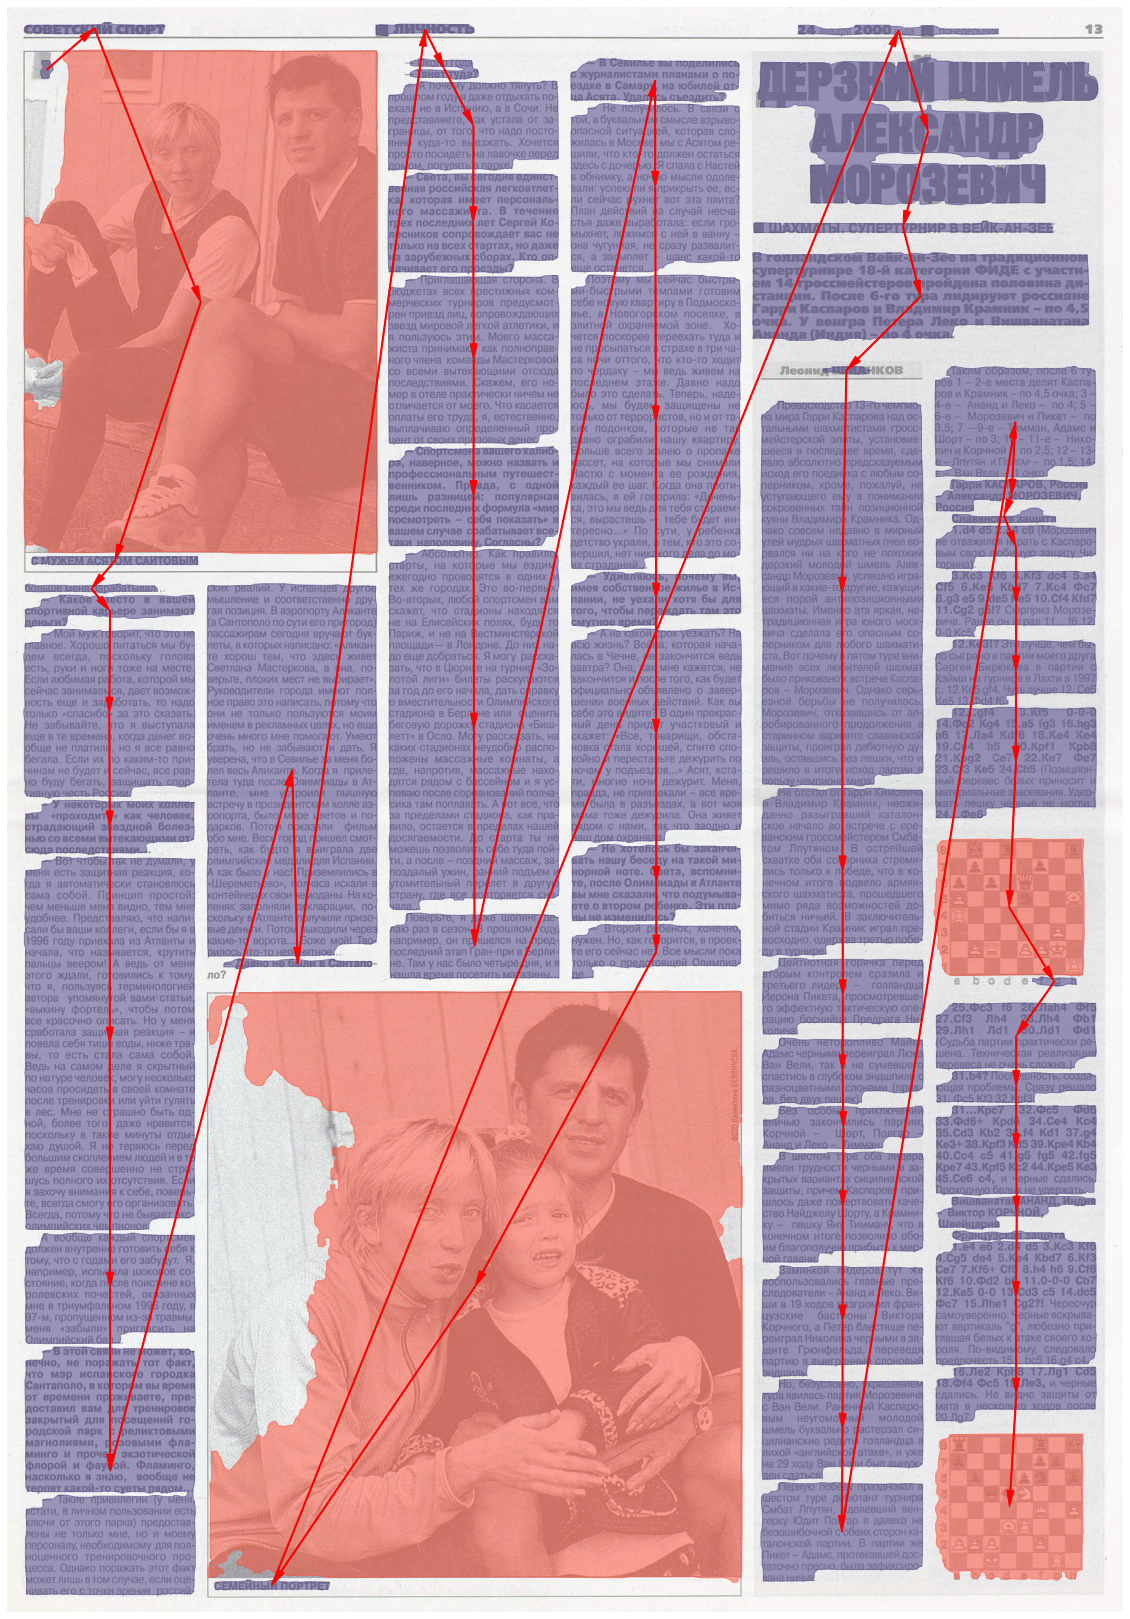

In [82]:
import PIL.Image
from matplotlib import pyplot as plt
import matplotlib


def render2img(
    source_image, 
    regions,
    classes=CLASSES_SEGMENTATION,
    figsize=(20, 30),
    region_style={
        'linewidth': 1,
        'alpha': 0.5,
    },
    shape_style={
        'linewidth': 0.5,
        'alpha': 0.5,
        'color': 'orange',
    },
    order_style={
        'linewidth': 1.0,
        'alpha': 0.5,
        'color': 'red',
    },
    default_color=(1.0, 1.0, 1.0),
):
    colors = {
        cls['id']: [c / 255.0 for c in cls.get('color', default_color)] 
        for cls in classes
    }

    fig, ax = plt.subplots(1, figsize=figsize)
    if source_image is not None:
        ax.imshow(numpy.array(source_image), alpha=0.5, cmap='gray')

    geoms_dict = {}
    shapes_dict = {}   
    for region in regions:
        if 'geom' in region:
            if region['category_id'] not in geoms_dict:
                geoms_dict[region['category_id']] = []
            geoms_dict[region['category_id']].append(region['geom'])
                
    # Render
    for category_id, geoms in sorted(geoms_dict.items()):    
        ax.add_collection(
            matplotlib.collections.PatchCollection(
                [matplotlib.patches.Polygon(geom.exterior.coords) for geom in geoms],
                facecolor=colors.get(category_id, default_color),
                edgecolor=colors.get(category_id, default_color),
                **region_style,
            )
        )

    for category_id, shapes in sorted(shapes_dict.items()):
        for shape in shapes:
            plt.plot(
                [x for (x, y) in shape.coords],
                [y for (x, y) in shape.coords], 
                **shape_style,
            )

    # Order
    a = None
    for region in regions:
        b = region['geom']
        if a is not None:
            ax.arrow(
                (a.bounds[0] + a.bounds[2]) / 2,
                (a.bounds[1] + a.bounds[3]) / 2,
                (b.bounds[0] + b.bounds[2]) / 2 - (a.bounds[0] + a.bounds[2]) / 2,
                (b.bounds[1] + b.bounds[3]) / 2 - (a.bounds[1] + a.bounds[3]) / 2,
                color='red',
                alpha=1.0, 
                width=2, 
                head_width=13,
                head_length=30,
                length_includes_head=True,
            )
        a = b
    
    ax.set_axis_off()

    # Save Image
    img_buf = io.BytesIO()
    plt.savefig(img_buf, bbox_inches='tight')
    img_buf.seek(0)
    return img_buf.read()


rendered_preview = render2img(
    source_image=PIL.Image.open('boa-02-page_0013.jpeg'), 
    regions=ordered_regions,
)

## Install dependencies (python 3.8)

In [1]:
!python3.8 -m pip install --upgrade pip
!pip install shapely==2.0.1
!pip install networkx==3.1
!pip install intervaltree==3.1.0

DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author

## Tooling

Internal progress format convertation script for https://jsonata.org/